# Вступ

Вирази:
* `MА = max(MD)*(MT+MZ)-MT*MD`
* `E=В*МD+D*MT.`

Виконання роботи поділено на дві частини відповідно до завдання.



# Виконання

In [16]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import json
import sys
import time
from random import randint, uniform
from threading import Lock
from concurrent.futures import ThreadPoolExecutor, Future

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from loguru import logger

Імпорт необхідних бібліотек

In [18]:
np.random.seed(9313)

Встановлення зерна рандому



In [19]:
data_file_path = "data.json"
results_file_path = "results.json"
min_dimension = 100
max_dimension = 150

Ініціалізація глобальних констант

In [20]:
sns.set_style("whitegrid")

Встановлення стилю для графіків

In [21]:
matrixes_MA = []
vectors_E = []

Змінні, куди будуть записуватись результати обрахунків

In [22]:
logger.remove()
logger.add(
    sys.stderr,
    format="<red>[{level}]</red> Message : <green>{message}</green> @ {time}",
    colorize=True,
)
logger.add("logs.log")

4

Налаштування логера

In [23]:
with open(data_file_path, "w") as f:
    vectors_B = [list(np.random.rand(n)) for n in range(min_dimension, max_dimension)]
    vectors_D = [list(np.random.rand(n)) for n in range(min_dimension, max_dimension)]
    matrixes_MT = [
        np.random.rand(n, n).tolist() for n in range(min_dimension, max_dimension)
    ]
    matrixes_MZ = [
        np.random.rand(n, n).tolist() for n in range(min_dimension, max_dimension)
    ]
    matrixes_MD = [
        np.random.rand(n, n).tolist() for n in range(min_dimension, max_dimension)
    ]
    json.dump(
        {
            "vectors_B": vectors_B,
            "vectors_D": vectors_D,
            "matrixes_MD": matrixes_MD,
            "matrixes_MT": matrixes_MT,
            "matrixes_MZ": matrixes_MZ
        }, 
      f
    )

Генерація початкових даних та запис їх у файл

In [24]:
matrixes_MA = []
vectors_E = []

In [25]:
threadlock = Lock()

In [26]:
class FirstExpressionThread:
    result_value, first_part, second_part = None, None, None

    def __init__(self, vector_B, vector_D, matrix_MD, matrix_MT, matrix_MZ) -> None:
        self.vector_B = vector_B
        self.vector_D = vector_D
        self.matrix_MD = matrix_MD
        self.matrix_MT = matrix_MT
        self.matrix_MZ = matrix_MZ

    def first_part_thread(self, thread_num):
        logger.info(f"Starting {thread_num} thread...")

        threadlock.acquire()
        self.first_part = np.dot(self.matrix_MT, self.matrix_MD)
        print(self.first_part)
        threadlock.release()

        logger.success(f"Finishing {thread_num} thread...")

    def second_part_thread(self, thread_num):
        logger.info(f"Starting {thread_num} thread...")

        threadlock.acquire()
        self.second_part = np.dot(np.max(self.matrix_MD), np.sum([self.matrix_MT, self.matrix_MZ]))
        print(self.second_part)
        threadlock.release()

        logger.success(f"Finishing {thread_num} thread...")

    def final_part_thread(self, thread_num):
        logger.info(f"Starting {thread_num} thread...")

        threadlock.acquire()
        result = np.subtract(self.first_part, self.second_part)
        matrixes_MA.append(result.tolist())
        print(result)
        threadlock.release()

        logger.success(f"Finishing {thread_num} thread...")

In [27]:
class SecondExpressionThread:
    result_value, first_part, second_part = None, None, None

    def __init__(self, vector_B, vector_D, matrix_MD, matrix_MT, matrix_MZ) -> None:
        self.vector_B = vector_B
        self.vector_D = vector_D
        self.matrix_MD = matrix_MD
        self.matrix_MT = matrix_MT
        self.matrix_MZ = matrix_MZ

    def first_part_thread(self, thread_num):
        logger.info(f"Starting {thread_num} thread...")

        threadlock.acquire()
        self.first_part = np.dot(self.vector_B, self.matrix_MD)
        print(self.first_part)
        threadlock.release()

        logger.success(f"Finishing {thread_num} thread...")

    def second_part_thread(self, thread_num):
        logger.info(f"Starting {thread_num} thread...")
        
        threadlock.acquire()
        self.second_part = np.dot(self.vector_D, self.matrix_MT)
        print(self.second_part)
        threadlock.release()

        logger.success(f"Finishing {thread_num} thread...")

    def final_part_thread(self, thread_num):
        logger.info(f"Starting {thread_num} thread...")

        threadlock.acquire()
        result = np.add(self.first_part, self.second_part)
        vectors_E.append(result.tolist())
        print(result)
        threadlock.release()

        logger.success(f"Finishing {thread_num} thread...")

Створення класів для обрахунку частини виразів в різних потоках

In [28]:
xs1, xs2 = [], []
ys = []
with open("data.json", "r") as f:
    data = json.load(f)
    for index in range(max_dimension - min_dimension):
        start = time.time()
        main_thread = FirstExpressionThread(
            data["vectors_B"][index],
            data["vectors_D"][index],
            data["matrixes_MD"][index],
            data["matrixes_MT"][index],
            data["matrixes_MZ"][index],
        )

        with ThreadPoolExecutor() as executor:
            future_1 = executor.submit(lambda: main_thread.first_part_thread(index+1))
            future_2 = executor.submit(lambda: main_thread.second_part_thread(index+1))

            future_1.result()
            future_2.result()

            future_3 = executor.submit(lambda: main_thread.final_part_thread(index+1))
            future_3.result()

            executor.shutdown()

        end = time.time()
        seconds = end - start
        xs1.append(seconds)
        ys.append(index + min_dimension)

    for index in range(max_dimension - min_dimension):
        main_thread = SecondExpressionThread(
            data["vectors_B"][index],
            data["vectors_D"][index],
            data["matrixes_MD"][index],
            data["matrixes_MT"][index],
            data["matrixes_MZ"][index],
        )

        with ThreadPoolExecutor() as executor:
            future_1 = executor.submit(lambda: main_thread.first_part_thread(index+1))
            future_2 = executor.submit(lambda: main_thread.second_part_thread(index+1))

            future_1.result()
            future_2.result()

            future_3 = executor.submit(lambda: main_thread.final_part_thread(index+1))
            future_3.result()

            executor.shutdown()

        end = time.time()
        seconds = end - start
        xs2.append(seconds)
        logger.info(f"The time of {index + 1} thread was {seconds}")

[INFO] Message : Starting 1 thread... @ 2023-03-18T18:28:42.491433+0000
[INFO] Message : Starting 1 thread... @ 2023-03-18T18:28:42.503692+0000
[SUCCESS] Message : Finishing 1 thread... @ 2023-03-18T18:28:42.511999+0000
[SUCCESS] Message : Finishing 1 thread... @ 2023-03-18T18:28:42.519097+0000
[INFO] Message : Starting 1 thread... @ 2023-03-18T18:28:42.521988+0000
[SUCCESS] Message : Finishing 1 thread... @ 2023-03-18T18:28:42.525955+0000
[INFO] Message : Starting 2 thread... @ 2023-03-18T18:28:42.531170+0000
[INFO] Message : Starting 2 thread... @ 2023-03-18T18:28:42.537045+0000
[SUCCESS] Message : Finishing 2 thread... @ 2023-03-18T18:28:42.547172+0000
[SUCCESS] Message : Finishing 2 thread... @ 2023-03-18T18:28:42.551722+0000
[INFO] Message : Starting 2 thread... @ 2023-03-18T18:28:42.557420+0000
[SUCCESS] Message : Finishing 2 thread... @ 2023-03-18T18:28:42.560641+0000
[INFO] Message : Starting 3 thread... @ 2023-03-18T18:28:42.566054+0000
[INFO] Message : Starting 3 thread... @ 

[[27.19001819 25.89339746 28.1268263  ... 28.22343404 26.64006165
  25.40871302]
 [23.21319692 21.88909242 22.92732022 ... 23.97988401 21.74828162
  21.99675355]
 [24.76309282 24.22106488 26.54118551 ... 27.79458481 24.03433744
  24.83796567]
 ...
 [24.91441841 25.53573338 24.35354673 ... 26.01346839 22.90744566
  25.03512758]
 [26.96857426 24.59727412 27.31219652 ... 27.19190865 24.60804841
  26.2197475 ]
 [27.01860268 27.67774382 28.71202263 ... 29.17740051 25.52719562
  27.67093096]]
10056.33383749137
[[-10029.1438193  -10030.44044004 -10028.20701119 ... -10028.11040345
  -10029.69377585 -10030.92512447]
 [-10033.12064057 -10034.44474508 -10033.40651727 ... -10032.35395348
  -10034.58555587 -10034.33708394]
 [-10031.57074467 -10032.11277261 -10029.79265198 ... -10028.53925268
  -10032.29950005 -10031.49587182]
 ...
 [-10031.41941908 -10030.79810411 -10031.98029076 ... -10030.32036911
  -10033.42639183 -10031.29870992]
 [-10029.36526324 -10031.73656337 -10029.02164097 ... -10029.1419

[INFO] Message : Starting 5 thread... @ 2023-03-18T18:28:42.781333+0000
[INFO] Message : Starting 5 thread... @ 2023-03-18T18:28:42.790985+0000
[SUCCESS] Message : Finishing 5 thread... @ 2023-03-18T18:28:42.797972+0000
[SUCCESS] Message : Finishing 5 thread... @ 2023-03-18T18:28:42.805473+0000
[INFO] Message : Starting 5 thread... @ 2023-03-18T18:28:42.808057+0000
[SUCCESS] Message : Finishing 5 thread... @ 2023-03-18T18:28:42.812087+0000
[INFO] Message : Starting 6 thread... @ 2023-03-18T18:28:42.815607+0000
[INFO] Message : Starting 6 thread... @ 2023-03-18T18:28:42.832300+0000
[SUCCESS] Message : Finishing 6 thread... @ 2023-03-18T18:28:42.836855+0000
[SUCCESS] Message : Finishing 6 thread... @ 2023-03-18T18:28:42.844469+0000
[INFO] Message : Starting 6 thread... @ 2023-03-18T18:28:42.846873+0000
[SUCCESS] Message : Finishing 6 thread... @ 2023-03-18T18:28:42.849662+0000
[INFO] Message : Starting 7 thread... @ 2023-03-18T18:28:42.854881+0000
[INFO] Message : Starting 7 thread... @ 

[[23.46826394 23.04818138 25.29424533 ... 26.04811521 27.35508019
  24.41554764]
 [26.41134968 27.49476781 28.25734808 ... 28.5558171  29.06396129
  27.71725969]
 [25.90250061 26.33465115 28.39401138 ... 28.01747659 26.69018719
  25.86710724]
 ...
 [20.74753476 18.91344641 22.07535222 ... 21.33104878 23.95812854
  20.00943113]
 [22.14889933 23.00963414 26.00882246 ... 24.99703237 24.56120974
  24.25997614]
 [21.3076729  21.91523289 24.15245556 ... 23.69122561 23.66197421
  23.29725665]]
10783.460708848557
[[-10759.99244491 -10760.41252747 -10758.16646352 ... -10757.41259364
  -10756.10562866 -10759.04516121]
 [-10757.04935917 -10755.96594104 -10755.20336076 ... -10754.90489175
  -10754.39674756 -10755.74344916]
 [-10757.55820824 -10757.1260577  -10755.06669747 ... -10755.44323226
  -10756.77052165 -10757.5936016 ]
 ...
 [-10762.71317409 -10764.54726243 -10761.38535663 ... -10762.12966006
  -10759.50258031 -10763.45127772]
 [-10761.31180952 -10760.45107471 -10757.45188639 ... -10758.463

[SUCCESS] Message : Finishing 9 thread... @ 2023-03-18T18:28:43.017521+0000
[INFO] Message : Starting 10 thread... @ 2023-03-18T18:28:43.034250+0000
[INFO] Message : Starting 10 thread... @ 2023-03-18T18:28:43.042679+0000
[SUCCESS] Message : Finishing 10 thread... @ 2023-03-18T18:28:43.044697+0000
[SUCCESS] Message : Finishing 10 thread... @ 2023-03-18T18:28:43.062552+0000
[INFO] Message : Starting 10 thread... @ 2023-03-18T18:28:43.067401+0000
[SUCCESS] Message : Finishing 10 thread... @ 2023-03-18T18:28:43.071779+0000
[INFO] Message : Starting 11 thread... @ 2023-03-18T18:28:43.078196+0000
[INFO] Message : Starting 11 thread... @ 2023-03-18T18:28:43.091095+0000
[SUCCESS] Message : Finishing 11 thread... @ 2023-03-18T18:28:43.106955+0000
[SUCCESS] Message : Finishing 11 thread... @ 2023-03-18T18:28:43.111980+0000
[INFO] Message : Starting 11 thread... @ 2023-03-18T18:28:43.132374+0000
[SUCCESS] Message : Finishing 11 thread... @ 2023-03-18T18:28:43.146802+0000
[INFO] Message : Startin

[[-11659.37277641 -11658.05096293 -11661.12431423 ... -11661.86530321
  -11659.63181471 -11660.87101236]
 [-11660.4374489  -11659.12331761 -11662.3308827  ... -11664.3180821
  -11660.50929446 -11662.42346641]
 [-11658.21558689 -11657.4744798  -11661.70311318 ... -11662.69936641
  -11659.64947303 -11660.89557528]
 ...
 [-11654.30132799 -11652.04170949 -11654.99778566 ... -11659.02485746
  -11654.3469602  -11656.51892001]
 [-11658.51120345 -11657.2120716  -11660.73814607 ... -11663.20098907
  -11658.71135625 -11661.19761975]
 [-11658.25575778 -11655.6948016  -11660.30480565 ... -11662.08825093
  -11658.55488248 -11659.81856084]]
[[25.31563689 25.81853312 26.4600844  ... 25.38473503 24.9871833
  27.09366627]
 [23.89562107 25.4915779  24.64243901 ... 26.40668993 24.63089124
  26.37059749]
 [27.44665254 28.59963295 28.88415858 ... 29.43529693 27.80945175
  30.23175577]
 ...
 [28.11359753 31.82387153 31.5272484  ... 29.17922565 30.05022916
  30.86932442]
 [25.0147734  26.48465676 25.18792888

[SUCCESS] Message : Finishing 13 thread... @ 2023-03-18T18:28:43.230947+0000
[INFO] Message : Starting 13 thread... @ 2023-03-18T18:28:43.233424+0000
[SUCCESS] Message : Finishing 13 thread... @ 2023-03-18T18:28:43.247900+0000
[INFO] Message : Starting 13 thread... @ 2023-03-18T18:28:43.251625+0000
[SUCCESS] Message : Finishing 13 thread... @ 2023-03-18T18:28:43.254884+0000
[INFO] Message : Starting 14 thread... @ 2023-03-18T18:28:43.260507+0000
[INFO] Message : Starting 14 thread... @ 2023-03-18T18:28:43.276526+0000
[SUCCESS] Message : Finishing 14 thread... @ 2023-03-18T18:28:43.283828+0000
[SUCCESS] Message : Finishing 14 thread... @ 2023-03-18T18:28:43.290344+0000
[INFO] Message : Starting 14 thread... @ 2023-03-18T18:28:43.297065+0000
[SUCCESS] Message : Finishing 14 thread... @ 2023-03-18T18:28:43.303217+0000
[INFO] Message : Starting 15 thread... @ 2023-03-18T18:28:43.308654+0000
[INFO] Message : Starting 15 thread... @ 2023-03-18T18:28:43.314972+0000
[SUCCESS] Message : Finishi

[[30.28335279 27.31503809 28.4225676  ... 28.99153658 25.14475714
  29.3964277 ]
 [28.86780302 27.04608856 27.57107238 ... 28.50013598 26.80629385
  29.32077673]
 [27.91623683 26.67298736 27.88971394 ... 27.93856523 25.51998832
  26.82351133]
 ...
 [29.52834894 28.52491839 29.16928507 ... 30.14883961 26.80553264
  31.59650257]
 [28.27386458 26.72417519 28.2637564  ... 27.49870911 25.89366919
  27.47009479]
 [28.08076752 28.07198974 28.93837363 ... 29.87605578 25.03942938
  28.89017618]]
12518.996923406086
[[-12488.71357062 -12491.68188531 -12490.57435581 ... -12490.00538682
  -12493.85216627 -12489.60049571]
 [-12490.12912039 -12491.95083485 -12491.42585102 ... -12490.49678743
  -12492.19062956 -12489.67614667]
 [-12491.08068658 -12492.32393604 -12491.10720946 ... -12491.05835818
  -12493.47693509 -12492.17341207]
 ...
 [-12489.46857447 -12490.47200501 -12489.82763834 ... -12488.8480838
  -12492.19139076 -12487.40042084]
 [-12490.72305882 -12492.27274822 -12490.73316701 ... -12491.4982

[SUCCESS] Message : Finishing 17 thread... @ 2023-03-18T18:28:43.437597+0000
[SUCCESS] Message : Finishing 17 thread... @ 2023-03-18T18:28:43.430612+0000
[INFO] Message : Starting 17 thread... @ 2023-03-18T18:28:43.444454+0000
[SUCCESS] Message : Finishing 17 thread... @ 2023-03-18T18:28:43.447599+0000
[INFO] Message : Starting 18 thread... @ 2023-03-18T18:28:43.452682+0000
[INFO] Message : Starting 18 thread... @ 2023-03-18T18:28:43.464438+0000
[SUCCESS] Message : Finishing 18 thread... @ 2023-03-18T18:28:43.471004+0000
[SUCCESS] Message : Finishing 18 thread... @ 2023-03-18T18:28:43.481399+0000
[INFO] Message : Starting 18 thread... @ 2023-03-18T18:28:43.483714+0000
[SUCCESS] Message : Finishing 18 thread... @ 2023-03-18T18:28:43.486460+0000
[INFO] Message : Starting 19 thread... @ 2023-03-18T18:28:43.493663+0000
[INFO] Message : Starting 19 thread... @ 2023-03-18T18:28:43.503008+0000
[SUCCESS] Message : Finishing 19 thread... @ 2023-03-18T18:28:43.507871+0000
[SUCCESS] Message : Fin

13392.04180550341
[[-13362.44847387 -13363.60107749 -13362.80814926 ... -13362.45687804
  -13363.48810721 -13362.98632846]
 [-13362.42589854 -13363.58771557 -13361.53946038 ... -13363.77093716
  -13365.38899458 -13363.31186746]
 [-13360.39374069 -13361.87587808 -13360.98519117 ... -13360.45683962
  -13361.36689292 -13361.69793686]
 ...
 [-13361.47315716 -13363.11908203 -13362.28926144 ... -13362.45259725
  -13364.22250191 -13364.05819977]
 [-13363.06579781 -13363.11696073 -13366.36197667 ... -13366.25453745
  -13365.99733649 -13365.4907199 ]
 [-13361.55768632 -13360.35139536 -13361.93712595 ... -13361.94132683
  -13361.9106367  -13361.92202819]]
[[28.82839637 32.8754265  31.22474393 ... 32.03129638 28.95888441
  31.3664724 ]
 [28.78925754 32.69242825 31.55004886 ... 30.83833153 29.947968
  30.73150551]
 [29.79321289 35.44964305 35.37561563 ... 33.1671972  29.64093277
  32.48586564]
 ...
 [25.21372279 29.27527328 26.87988196 ... 27.72594991 25.66112373
  28.43341544]
 [29.63470905 32.50

[SUCCESS] Message : Finishing 22 thread... @ 2023-03-18T18:28:43.637437+0000
[SUCCESS] Message : Finishing 22 thread... @ 2023-03-18T18:28:43.647672+0000
[INFO] Message : Starting 22 thread... @ 2023-03-18T18:28:43.650451+0000
[SUCCESS] Message : Finishing 22 thread... @ 2023-03-18T18:28:43.653498+0000
[INFO] Message : Starting 23 thread... @ 2023-03-18T18:28:43.664103+0000
[INFO] Message : Starting 23 thread... @ 2023-03-18T18:28:43.664809+0000
[SUCCESS] Message : Finishing 23 thread... @ 2023-03-18T18:28:43.684819+0000
[SUCCESS] Message : Finishing 23 thread... @ 2023-03-18T18:28:43.693539+0000
[INFO] Message : Starting 23 thread... @ 2023-03-18T18:28:43.697971+0000
[SUCCESS] Message : Finishing 23 thread... @ 2023-03-18T18:28:43.703627+0000
[INFO] Message : Starting 24 thread... @ 2023-03-18T18:28:43.707139+0000
[INFO] Message : Starting 24 thread... @ 2023-03-18T18:28:43.716317+0000
[SUCCESS] Message : Finishing 24 thread... @ 2023-03-18T18:28:43.724064+0000
[SUCCESS] Message : Fin

14600.935275593
[[-14574.34457276 -14570.41495005 -14570.79932025 ... -14569.28040246
  -14570.63557306 -14569.36731555]
 [-14572.87552445 -14571.52364009 -14569.69408775 ... -14570.04636825
  -14571.1165186  -14569.32089458]
 [-14569.60597807 -14564.72978486 -14568.13491555 ... -14565.75463994
  -14569.52391325 -14565.553316  ]
 ...
 [-14573.85439266 -14569.67297983 -14571.60763234 ... -14569.36662306
  -14570.88222289 -14571.10799278]
 [-14574.68143117 -14571.79424431 -14572.74428902 ... -14572.22056297
  -14574.05966053 -14572.29374526]
 [-14570.07438955 -14567.5779427  -14568.84243965 ... -14567.22388747
  -14569.96349015 -14567.79503707]]
[[33.84671509 32.66259269 31.80344256 ... 35.77330755 33.31595993
  31.02394323]
 [31.47894876 28.95032161 27.98757146 ... 28.9034512  30.01118131
  25.07447115]
 [33.55648158 30.28013149 31.3651564  ... 33.74444948 33.15539121
  29.42026658]
 ...
 [31.70370815 27.98241815 28.30292079 ... 30.5190396  29.02299158
  26.54108407]
 [33.9546196  32.14

[SUCCESS] Message : Finishing 26 thread... @ 2023-03-18T18:28:43.852289+0000
[INFO] Message : Starting 27 thread... @ 2023-03-18T18:28:43.855920+0000
[INFO] Message : Starting 27 thread... @ 2023-03-18T18:28:43.865435+0000
[SUCCESS] Message : Finishing 27 thread... @ 2023-03-18T18:28:43.877319+0000
[SUCCESS] Message : Finishing 27 thread... @ 2023-03-18T18:28:43.886607+0000
[INFO] Message : Starting 27 thread... @ 2023-03-18T18:28:43.889852+0000
[SUCCESS] Message : Finishing 27 thread... @ 2023-03-18T18:28:43.901310+0000
[INFO] Message : Starting 28 thread... @ 2023-03-18T18:28:43.904384+0000
[INFO] Message : Starting 28 thread... @ 2023-03-18T18:28:43.911667+0000
[SUCCESS] Message : Finishing 28 thread... @ 2023-03-18T18:28:43.915984+0000
[SUCCESS] Message : Finishing 28 thread... @ 2023-03-18T18:28:43.926207+0000
[INFO] Message : Starting 28 thread... @ 2023-03-18T18:28:43.929013+0000
[SUCCESS] Message : Finishing 28 thread... @ 2023-03-18T18:28:43.934800+0000
[INFO] Message : Starti

[[-15674.27267005 -15675.31454937 -15676.43280256 ... -15676.12823375
  -15678.44843085 -15675.28177653]
 [-15678.90671468 -15678.6463014  -15678.61790513 ... -15680.3056183
  -15681.6626373  -15678.98251574]
 [-15680.59302292 -15681.36818765 -15677.20444496 ... -15680.37084525
  -15683.45002474 -15681.22892965]
 ...
 [-15678.70917395 -15678.08627464 -15677.15058656 ... -15679.35922555
  -15679.2943848  -15678.98334829]
 [-15677.54503933 -15675.56389085 -15675.09351787 ... -15676.7088534
  -15679.68146976 -15676.5335131 ]
 [-15679.0956179  -15676.50073518 -15675.59200216 ... -15677.82773772
  -15681.75868847 -15676.40068909]]
[[32.54396869 28.77043238 32.25394301 ... 31.38400124 33.99082302
  32.9379628 ]
 [30.95604407 28.2660613  30.11707559 ... 28.48357522 32.08489322
  29.16153683]
 [30.40909266 30.56306879 29.84310111 ... 29.71501049 33.13404688
  32.08985762]
 ...
 [33.10966925 30.23102481 30.70892802 ... 30.6248606  33.26184945
  33.55968265]
 [28.09769747 25.91309425 27.86751636

[INFO] Message : Starting 31 thread... @ 2023-03-18T18:28:44.057209+0000
[SUCCESS] Message : Finishing 31 thread... @ 2023-03-18T18:28:44.066709+0000
[SUCCESS] Message : Finishing 31 thread... @ 2023-03-18T18:28:44.077461+0000
[INFO] Message : Starting 31 thread... @ 2023-03-18T18:28:44.082501+0000
[SUCCESS] Message : Finishing 31 thread... @ 2023-03-18T18:28:44.086592+0000
[INFO] Message : Starting 32 thread... @ 2023-03-18T18:28:44.102303+0000
[INFO] Message : Starting 32 thread... @ 2023-03-18T18:28:44.104197+0000
[SUCCESS] Message : Finishing 32 thread... @ 2023-03-18T18:28:44.122249+0000
[SUCCESS] Message : Finishing 32 thread... @ 2023-03-18T18:28:44.133164+0000
[INFO] Message : Starting 32 thread... @ 2023-03-18T18:28:44.136998+0000
[SUCCESS] Message : Finishing 32 thread... @ 2023-03-18T18:28:44.147592+0000
[INFO] Message : Starting 33 thread... @ 2023-03-18T18:28:44.157507+0000
[INFO] Message : Starting 33 thread... @ 2023-03-18T18:28:44.162143+0000
[SUCCESS] Message : Finishi

[[33.14433439 30.75205846 30.5177045  ... 28.01434007 29.17204627
  32.09390273]
 [32.87083622 29.38487904 31.5086809  ... 28.52965085 30.08102568
  31.2228854 ]
 [35.03940702 32.15089787 32.68508822 ... 28.5383006  29.7045514
  30.6326422 ]
 ...
 [35.69218145 31.77000721 33.17789858 ... 28.82739623 29.97283394
  32.39879035]
 [33.87238674 31.14674711 33.47900843 ... 30.41398883 29.57648499
  31.40097226]
 [38.46965916 34.30898508 34.77525615 ... 32.80276094 33.14877106
  34.04015342]]
16922.5913933775
[[-16889.44705898 -16891.83933492 -16892.07368888 ... -16894.57705331
  -16893.41934711 -16890.49749064]
 [-16889.72055716 -16893.20651434 -16891.08271248 ... -16894.06174253
  -16892.5103677  -16891.36850797]
 [-16887.55198635 -16890.44049551 -16889.90630516 ... -16894.05309278
  -16892.88684198 -16891.95875117]
 ...
 [-16886.89921192 -16890.82138617 -16889.41349479 ... -16893.76399714
  -16892.61855943 -16890.19260303]
 [-16888.71900663 -16891.44464627 -16889.11238495 ... -16892.177404

[INFO] Message : Starting 35 thread... @ 2023-03-18T18:28:44.271847+0000
[SUCCESS] Message : Finishing 35 thread... @ 2023-03-18T18:28:44.288803+0000
[SUCCESS] Message : Finishing 35 thread... @ 2023-03-18T18:28:44.297889+0000
[INFO] Message : Starting 35 thread... @ 2023-03-18T18:28:44.302425+0000
[SUCCESS] Message : Finishing 35 thread... @ 2023-03-18T18:28:44.311311+0000
[INFO] Message : Starting 36 thread... @ 2023-03-18T18:28:44.316832+0000
[INFO] Message : Starting 36 thread... @ 2023-03-18T18:28:44.318213+0000
[SUCCESS] Message : Finishing 36 thread... @ 2023-03-18T18:28:44.337256+0000
[SUCCESS] Message : Finishing 36 thread... @ 2023-03-18T18:28:44.355834+0000
[INFO] Message : Starting 36 thread... @ 2023-03-18T18:28:44.358182+0000
[SUCCESS] Message : Finishing 36 thread... @ 2023-03-18T18:28:44.362141+0000
[INFO] Message : Starting 37 thread... @ 2023-03-18T18:28:44.365640+0000
[INFO] Message : Starting 37 thread... @ 2023-03-18T18:28:44.380012+0000
[SUCCESS] Message : Finishi

[[32.81117543 33.39027168 34.15150292 ... 32.89456969 33.81826708
  34.8848465 ]
 [33.01126939 35.33336305 34.73232861 ... 35.88773847 34.17741287
  35.82478944]
 [30.47988703 34.10519273 33.8978793  ... 34.0767718  30.80725796
  31.38998513]
 ...
 [31.58309533 35.34932699 34.83830402 ... 32.71505311 32.79067955
  36.82679952]
 [33.37803626 37.01189502 35.16333166 ... 36.74578068 35.17761242
  36.25309117]
 [29.42731482 32.11736522 32.78710389 ... 32.60886656 31.9471181
  32.91342581]]
17876.358385237072
[[-17843.54720981 -17842.96811356 -17842.20688232 ... -17843.46381555
  -17842.54011815 -17841.47353874]
 [-17843.34711585 -17841.02502219 -17841.62605662 ... -17840.47064677
  -17842.18097237 -17840.5335958 ]
 [-17845.87849821 -17842.25319251 -17842.46050594 ... -17842.28161344
  -17845.55112728 -17844.96840011]
 ...
 [-17844.7752899  -17841.00905825 -17841.52008121 ... -17843.64333212
  -17843.56770568 -17839.53158571]
 [-17842.98034898 -17839.34649022 -17841.19505357 ... -17839.6126

[INFO] Message : Starting 40 thread... @ 2023-03-18T18:28:44.492463+0000
[INFO] Message : Starting 40 thread... @ 2023-03-18T18:28:44.504624+0000
[SUCCESS] Message : Finishing 40 thread... @ 2023-03-18T18:28:44.511447+0000
[SUCCESS] Message : Finishing 40 thread... @ 2023-03-18T18:28:44.525990+0000
[INFO] Message : Starting 40 thread... @ 2023-03-18T18:28:44.528236+0000
[SUCCESS] Message : Finishing 40 thread... @ 2023-03-18T18:28:44.531367+0000
[INFO] Message : Starting 41 thread... @ 2023-03-18T18:28:44.539195+0000
[INFO] Message : Starting 41 thread... @ 2023-03-18T18:28:44.549396+0000
[SUCCESS] Message : Finishing 41 thread... @ 2023-03-18T18:28:44.555405+0000
[SUCCESS] Message : Finishing 41 thread... @ 2023-03-18T18:28:44.566404+0000
[INFO] Message : Starting 41 thread... @ 2023-03-18T18:28:44.569367+0000
[SUCCESS] Message : Finishing 41 thread... @ 2023-03-18T18:28:44.572636+0000
[INFO] Message : Starting 42 thread... @ 2023-03-18T18:28:44.577067+0000
[INFO] Message : Starting 4

[[35.57717323 35.53155284 36.00010065 ... 37.82421067 37.49957369
  33.61063267]
 [36.41789794 34.53113847 33.79363905 ... 37.6455449  36.30392557
  33.63636346]
 [32.09120725 29.97726808 28.67502805 ... 31.42892117 29.76337477
  27.22274194]
 ...
 [33.68281076 34.60260425 35.89099766 ... 35.04349242 36.79801541
  33.96650355]
 [35.09680929 34.14005729 35.61403116 ... 35.66413948 36.48784184
  32.37762399]
 [34.5017008  32.29706915 34.03505262 ... 35.64400057 34.12026021
  31.56280463]]
19394.57445903602
[[-19358.99728581 -19359.04290619 -19358.57435839 ... -19356.75024837
  -19357.07488534 -19360.96382636]
 [-19358.15656109 -19360.04332056 -19360.78081999 ... -19356.92891413
  -19358.27053347 -19360.93809558]
 [-19362.48325178 -19364.59719095 -19365.89943099 ... -19363.14553786
  -19364.81108427 -19367.3517171 ]
 ...
 [-19360.89164827 -19359.97185479 -19358.68346138 ... -19359.53096662
  -19357.77644362 -19360.60795548]
 [-19359.47764974 -19360.43440174 -19358.96042788 ... -19358.9103

[SUCCESS] Message : Finishing 44 thread... @ 2023-03-18T18:28:44.713719+0000
[SUCCESS] Message : Finishing 44 thread... @ 2023-03-18T18:28:44.743032+0000
[INFO] Message : Starting 44 thread... @ 2023-03-18T18:28:44.747687+0000
[SUCCESS] Message : Finishing 44 thread... @ 2023-03-18T18:28:44.754201+0000
[INFO] Message : Starting 45 thread... @ 2023-03-18T18:28:44.762004+0000
[INFO] Message : Starting 45 thread... @ 2023-03-18T18:28:44.763264+0000
[SUCCESS] Message : Finishing 45 thread... @ 2023-03-18T18:28:44.798852+0000
[SUCCESS] Message : Finishing 45 thread... @ 2023-03-18T18:28:44.810811+0000
[INFO] Message : Starting 45 thread... @ 2023-03-18T18:28:44.813633+0000
[SUCCESS] Message : Finishing 45 thread... @ 2023-03-18T18:28:44.818767+0000
[INFO] Message : Starting 46 thread... @ 2023-03-18T18:28:44.825228+0000
[INFO] Message : Starting 46 thread... @ 2023-03-18T18:28:44.844354+0000
[SUCCESS] Message : Finishing 46 thread... @ 2023-03-18T18:28:44.850055+0000
[SUCCESS] Message : Fin

20433.246693106314
[[-20396.66124066 -20398.96585462 -20400.62938003 ... -20399.83228837
  -20398.62709636 -20398.10736124]
 [-20396.16143986 -20399.41635513 -20401.00484193 ... -20399.13885241
  -20397.94259275 -20400.43712092]
 [-20394.28095716 -20398.53714685 -20398.2035741  ... -20397.84909085
  -20397.33072109 -20398.88205736]
 ...
 [-20394.67849837 -20398.21487464 -20399.88720515 ... -20399.55396099
  -20396.10777431 -20397.31991784]
 [-20394.27206742 -20399.15368057 -20399.4818523  ... -20400.79195389
  -20397.74567517 -20397.136039  ]
 [-20395.93811343 -20401.78469173 -20400.65704561 ... -20401.92660998
  -20398.67850024 -20397.37276006]]
[[37.36821462 40.37500422 39.94443266 ... 39.31055259 35.58790177
  35.27436387]
 [35.82014337 38.55145575 38.64114225 ... 35.84519626 36.22843667
  34.9936744 ]
 [33.02992706 37.88300552 34.75477249 ... 37.09164742 34.92665857
  34.61890993]
 ...
 [36.15876805 39.1657668  37.68071663 ... 38.00361297 37.06202974
  35.41555602]
 [34.84800328 35

[SUCCESS] Message : Finishing 47 thread... @ 2023-03-18T18:28:44.922360+0000
[SUCCESS] Message : Finishing 47 thread... @ 2023-03-18T18:28:44.939725+0000
[INFO] Message : Starting 47 thread... @ 2023-03-18T18:28:44.943315+0000
[SUCCESS] Message : Finishing 47 thread... @ 2023-03-18T18:28:44.954956+0000
[INFO] Message : Starting 48 thread... @ 2023-03-18T18:28:44.962991+0000
[INFO] Message : Starting 48 thread... @ 2023-03-18T18:28:44.980526+0000
[SUCCESS] Message : Finishing 48 thread... @ 2023-03-18T18:28:44.987413+0000
[SUCCESS] Message : Finishing 48 thread... @ 2023-03-18T18:28:45.028875+0000
[INFO] Message : Starting 48 thread... @ 2023-03-18T18:28:45.043487+0000
[SUCCESS] Message : Finishing 48 thread... @ 2023-03-18T18:28:45.048814+0000
[INFO] Message : Starting 49 thread... @ 2023-03-18T18:28:45.061364+0000
[INFO] Message : Starting 49 thread... @ 2023-03-18T18:28:45.062491+0000
[SUCCESS] Message : Finishing 49 thread... @ 2023-03-18T18:28:45.086184+0000
[SUCCESS] Message : Fin

[[34.30026128 36.84722543 37.35230083 ... 34.27607869 35.61238263
  34.0496127 ]
 [33.64906629 36.40379342 35.56852533 ... 31.62048997 34.25639341
  32.24449189]
 [33.68503991 35.06734367 35.91882556 ... 34.33569085 31.52456821
  32.3914632 ]
 ...
 [34.95314465 40.14788685 39.17496553 ... 35.37385726 35.4413248
  33.54969547]
 [35.91500231 43.60550413 39.97730702 ... 37.80329202 36.3496105
  37.30036415]
 [37.65617138 40.40905174 39.44855076 ... 36.95719586 36.77282234
  36.58969726]]
21295.171780929108
[[-21260.87151965 -21258.3245555  -21257.8194801  ... -21260.89570224
  -21259.5593983  -21261.12216823]
 [-21261.52271464 -21258.76798751 -21259.6032556  ... -21263.55129096
  -21260.91538752 -21262.92728904]
 [-21261.48674102 -21260.10443726 -21259.25295536 ... -21260.83609008
  -21263.64721272 -21262.78031773]
 ...
 [-21260.21863628 -21255.02389408 -21255.9968154  ... -21259.79792367
  -21259.73045613 -21261.62208546]
 [-21259.25677862 -21251.5662768  -21255.19447391 ... -21257.36848

[INFO] Message : Starting 50 thread... @ 2023-03-18T18:28:45.121869+0000
[SUCCESS] Message : Finishing 50 thread... @ 2023-03-18T18:28:45.135374+0000
[SUCCESS] Message : Finishing 50 thread... @ 2023-03-18T18:28:45.152530+0000
[INFO] Message : Starting 50 thread... @ 2023-03-18T18:28:45.184592+0000
[SUCCESS] Message : Finishing 50 thread... @ 2023-03-18T18:28:45.193449+0000
[INFO] Message : Starting 1 thread... @ 2023-03-18T18:28:45.201738+0000
[INFO] Message : Starting 1 thread... @ 2023-03-18T18:28:45.209848+0000
[SUCCESS] Message : Finishing 1 thread... @ 2023-03-18T18:28:45.223191+0000
[SUCCESS] Message : Finishing 1 thread... @ 2023-03-18T18:28:45.230934+0000
[INFO] Message : Starting 1 thread... @ 2023-03-18T18:28:45.245824+0000
[SUCCESS] Message : Finishing 1 thread... @ 2023-03-18T18:28:45.255196+0000
[INFO] Message : The time of 1 thread was 0.14102411270141602 @ 2023-03-18T18:28:45.258802+0000
[INFO] Message : Starting 2 thread... @ 2023-03-18T18:28:45.262520+0000
[INFO] Mess

[[36.3439337  35.14321641 39.24213081 ... 36.8188176  36.41597836
  35.99177926]
 [38.41981377 39.23476709 39.86224468 ... 37.02746136 37.1290799
  35.08438503]
 [37.02954664 39.50913506 41.43929601 ... 36.13495515 38.49670209
  35.65483268]
 ...
 [37.16660041 38.87458217 39.06381941 ... 35.48377952 37.8335978
  33.77491686]
 [38.79300972 37.41259636 40.02792681 ... 37.66466826 38.27291868
  35.26856526]
 [38.1219664  40.33420568 42.87888107 ... 38.43630275 38.68829901
  35.76825523]]
22222.654220520668
[[-22186.31028682 -22187.51100411 -22183.41208971 ... -22185.83540292
  -22186.23824216 -22186.66244126]
 [-22184.23440675 -22183.41945343 -22182.79197584 ... -22185.62675916
  -22185.52514062 -22187.56983549]
 [-22185.62467388 -22183.14508546 -22181.21492451 ... -22186.51926537
  -22184.15751843 -22186.99938784]
 ...
 [-22185.48762011 -22183.77963835 -22183.59040111 ... -22187.170441
  -22184.82062272 -22188.87930366]
 [-22183.8612108  -22185.24162416 -22182.62629371 ... -22184.9895522

[SUCCESS] Message : Finishing 3 thread... @ 2023-03-18T18:28:45.355433+0000
[INFO] Message : Starting 3 thread... @ 2023-03-18T18:28:45.358153+0000
[SUCCESS] Message : Finishing 3 thread... @ 2023-03-18T18:28:45.360567+0000
[INFO] Message : The time of 3 thread was 0.24667859077453613 @ 2023-03-18T18:28:45.364453+0000
[INFO] Message : Starting 4 thread... @ 2023-03-18T18:28:45.378354+0000
[INFO] Message : Starting 4 thread... @ 2023-03-18T18:28:45.380345+0000
[SUCCESS] Message : Finishing 4 thread... @ 2023-03-18T18:28:45.392309+0000
[SUCCESS] Message : Finishing 4 thread... @ 2023-03-18T18:28:45.402449+0000
[INFO] Message : Starting 4 thread... @ 2023-03-18T18:28:45.405539+0000
[SUCCESS] Message : Finishing 4 thread... @ 2023-03-18T18:28:45.408407+0000
[INFO] Message : The time of 4 thread was 0.2981388568878174 @ 2023-03-18T18:28:45.415918+0000
[INFO] Message : Starting 5 thread... @ 2023-03-18T18:28:45.431801+0000
[INFO] Message : Starting 5 thread... @ 2023-03-18T18:28:45.433916+00

[23.81759295 24.63320187 25.53779997 22.2353314  24.31002512 23.51123547
 27.25754626 24.83765973 23.14898591 24.18286564 26.24571115 24.22925027
 25.46753936 21.79064786 26.76526242 23.12102413 24.65432529 24.04033358
 25.65693538 23.34066292 21.9582465  25.11999248 24.22034207 24.17581611
 25.19464556 27.66940631 26.0389026  27.72887192 22.65815286 26.16806391
 24.69949463 26.15112605 25.28227307 24.15857055 24.62628962 25.00746832
 27.16268041 26.00727233 25.3810897  27.67215417 24.87737297 21.03724809
 27.09176331 28.02299105 25.62526466 21.85545843 24.29626836 26.80198301
 22.78132634 26.92905612 25.52812041 23.64749382 22.55381992 24.621345
 26.20255068 25.19809295 25.4080545  24.68223133 26.92338218 23.18010745
 24.12134298 24.39692051 25.13881487 25.01439151 24.32332827 22.96453621
 24.44124562 24.88150281 26.14553465 27.15574504 24.43284754 22.56583242
 21.93671331 25.84344522 25.19939821 21.97131824 22.39370552 22.72302301
 23.32296601 26.3021086  22.37762785 26.72895594 24.9

[SUCCESS] Message : Finishing 7 thread... @ 2023-03-18T18:28:45.566422+0000
[SUCCESS] Message : Finishing 7 thread... @ 2023-03-18T18:28:45.575593+0000
[INFO] Message : Starting 7 thread... @ 2023-03-18T18:28:45.589126+0000
[SUCCESS] Message : Finishing 7 thread... @ 2023-03-18T18:28:45.591831+0000
[INFO] Message : The time of 7 thread was 0.4764363765716553 @ 2023-03-18T18:28:45.594210+0000
[INFO] Message : Starting 8 thread... @ 2023-03-18T18:28:45.602822+0000
[INFO] Message : Starting 8 thread... @ 2023-03-18T18:28:45.611298+0000
[SUCCESS] Message : Finishing 8 thread... @ 2023-03-18T18:28:45.633610+0000
[SUCCESS] Message : Finishing 8 thread... @ 2023-03-18T18:28:45.642482+0000
[INFO] Message : Starting 8 thread... @ 2023-03-18T18:28:45.669741+0000
[SUCCESS] Message : Finishing 8 thread... @ 2023-03-18T18:28:45.691834+0000
[INFO] Message : The time of 8 thread was 0.5782387256622314 @ 2023-03-18T18:28:45.696016+0000
[INFO] Message : Starting 9 thread... @ 2023-03-18T18:28:45.699718

[25.4066451  25.11405414 25.43726336 26.90197212 23.85127804 23.41670671
 25.2361251  29.00774352 23.87406856 25.43163765 28.26476203 25.13603411
 26.67825114 29.12600689 25.17851514 24.46277431 27.82945771 27.4528316
 26.11386126 26.47638297 23.50148318 24.88388357 26.31921256 25.70884363
 23.90862988 26.06942272 24.98258763 27.67253875 28.50699862 26.45366873
 25.89512485 23.59645518 26.52823452 24.88312135 27.02831893 26.18542395
 27.61656529 25.17698056 24.48304034 24.7620114  29.30751865 24.53651283
 25.98353764 25.48314043 24.62403339 25.48389626 27.34245557 24.40751383
 25.2171538  23.45765108 25.05956055 24.53666029 27.20332952 27.32287587
 23.8027062  25.39508583 27.39819624 26.57692986 28.85903492 25.35950247
 23.84331605 23.04203004 23.77190576 24.3304089  26.68005989 24.81614067
 22.73818071 23.05738431 24.62127072 25.23696    25.60194518 25.56550537
 26.44871407 23.61995741 26.43851166 24.29476698 23.50576524 26.30039277
 23.8682676  23.34605347 27.5821802  23.56379225 21.

[INFO] Message : Starting 10 thread... @ 2023-03-18T18:28:45.785359+0000
[SUCCESS] Message : Finishing 10 thread... @ 2023-03-18T18:28:45.791715+0000
[SUCCESS] Message : Finishing 10 thread... @ 2023-03-18T18:28:45.814196+0000
[INFO] Message : Starting 10 thread... @ 2023-03-18T18:28:45.816497+0000
[SUCCESS] Message : Finishing 10 thread... @ 2023-03-18T18:28:45.824495+0000
[INFO] Message : The time of 10 thread was 0.7137272357940674 @ 2023-03-18T18:28:45.831505+0000
[INFO] Message : Starting 11 thread... @ 2023-03-18T18:28:45.845101+0000
[INFO] Message : Starting 11 thread... @ 2023-03-18T18:28:45.856089+0000
[SUCCESS] Message : Finishing 11 thread... @ 2023-03-18T18:28:45.863995+0000
[SUCCESS] Message : Finishing 11 thread... @ 2023-03-18T18:28:45.878009+0000
[INFO] Message : Starting 11 thread... @ 2023-03-18T18:28:45.882791+0000
[SUCCESS] Message : Finishing 11 thread... @ 2023-03-18T18:28:45.888453+0000
[INFO] Message : The time of 11 thread was 0.7740449905395508 @ 2023-03-18T18

[24.42420306 26.80288336 26.37044563 26.79142983 27.38091244 26.97311688
 25.87798257 25.86547072 28.84599844 26.96628615 27.61392226 26.68184585
 26.48558734 25.55268999 26.69220685 27.11325415 25.80735703 26.55639121
 23.80159289 27.13897349 28.16038105 27.42508726 27.54518751 25.20547621
 26.62560042 26.04111288 24.67419958 25.36289995 24.53865997 24.55197289
 27.32299889 27.1360811  30.72744646 24.09174479 30.54712932 25.11963196
 27.16977126 26.42824348 24.93379713 25.95053152 25.12799421 24.69922773
 26.24662743 26.73556309 26.26480101 23.8406216  28.63171262 27.09503883
 25.91004782 24.87367808 25.94110914 25.05168286 28.16454238 26.36777861
 24.40105619 25.08967542 25.51020574 28.28753011 27.29572675 25.93658365
 25.80939055 24.96902544 26.04459739 25.5860485  28.96205442 24.8289245
 23.07895961 26.64604899 26.04357865 27.96769829 24.97152185 26.16501708
 28.61572171 25.50057457 24.19761196 24.70939103 28.40448006 28.78043824
 28.0047769  27.24059102 27.73129567 27.45840038 27.

[INFO] Message : Starting 13 thread... @ 2023-03-18T18:28:45.987098+0000
[SUCCESS] Message : Finishing 13 thread... @ 2023-03-18T18:28:45.992943+0000
[SUCCESS] Message : Finishing 13 thread... @ 2023-03-18T18:28:46.007964+0000
[INFO] Message : Starting 13 thread... @ 2023-03-18T18:28:46.012468+0000
[SUCCESS] Message : Finishing 13 thread... @ 2023-03-18T18:28:46.016843+0000
[INFO] Message : The time of 13 thread was 0.9040398597717285 @ 2023-03-18T18:28:46.021816+0000
[INFO] Message : Starting 14 thread... @ 2023-03-18T18:28:46.037137+0000
[INFO] Message : Starting 14 thread... @ 2023-03-18T18:28:46.049025+0000
[SUCCESS] Message : Finishing 14 thread... @ 2023-03-18T18:28:46.055170+0000
[SUCCESS] Message : Finishing 14 thread... @ 2023-03-18T18:28:46.073446+0000
[INFO] Message : Starting 14 thread... @ 2023-03-18T18:28:46.079362+0000
[SUCCESS] Message : Finishing 14 thread... @ 2023-03-18T18:28:46.085094+0000
[INFO] Message : The time of 14 thread was 0.9726336002349854 @ 2023-03-18T18


[25.97935926 25.73058661 28.95022639 27.43237455 25.72513027 27.19406725
 26.66326511 29.47997421 29.4620569  27.71389226 26.18068738 25.24094971
 27.14104363 25.90392538 25.76265297 27.14801419 28.40994256 29.0093221
 27.90583205 24.60092773 28.93911135 29.40951778 24.19154254 27.15557449
 28.81055001 28.58166086 25.0228131  24.08692995 27.49503525 27.92557586
 29.34358892 26.92021686 23.72429183 25.86145593 29.27142877 27.00400596
 27.22816161 24.41204375 27.25298912 28.18308332 23.83641307 28.81957135
 26.25228537 26.83102215 29.28061274 29.04551977 27.3972915  26.07945665
 28.49735799 25.32799952 28.38758419 25.33562633 26.50472354 29.482911
 29.45375361 27.62809906 25.10917914 26.67965005 27.12936366 29.9198391
 26.6881955  26.3386448  26.95999511 26.44578454 29.68284718 26.11543409
 27.27304283 27.43979122 24.03224885 26.98150675 24.88018552 29.23960866
 29.0688058  27.08449651 25.41856026 28.53200727 27.54618601 28.78514837
 27.41370652 27.16816849 27.00569694 30.13614857 25.36

[SUCCESS] Message : Finishing 16 thread... @ 2023-03-18T18:28:46.208183+0000
[INFO] Message : Starting 16 thread... @ 2023-03-18T18:28:46.210640+0000
[SUCCESS] Message : Finishing 16 thread... @ 2023-03-18T18:28:46.221123+0000
[INFO] Message : The time of 16 thread was 1.117896318435669 @ 2023-03-18T18:28:46.235680+0000
[INFO] Message : Starting 17 thread... @ 2023-03-18T18:28:46.244193+0000
[INFO] Message : Starting 17 thread... @ 2023-03-18T18:28:46.256112+0000
[SUCCESS] Message : Finishing 17 thread... @ 2023-03-18T18:28:46.261281+0000
[SUCCESS] Message : Finishing 17 thread... @ 2023-03-18T18:28:46.272045+0000
[INFO] Message : Starting 17 thread... @ 2023-03-18T18:28:46.274386+0000
[SUCCESS] Message : Finishing 17 thread... @ 2023-03-18T18:28:46.277100+0000
[INFO] Message : The time of 17 thread was 1.1682178974151611 @ 2023-03-18T18:28:46.286013+0000
[INFO] Message : Starting 18 thread... @ 2023-03-18T18:28:46.288313+0000
[INFO] Message : Starting 18 thread... @ 2023-03-18T18:28:4

[27.62850698 25.56899599 27.16544963 28.55789586 29.06364886 25.99242465
 28.96662778 25.67648324 27.63839618 30.41700075 31.54665549 28.68189763
 28.38689463 26.8328615  24.82314461 27.31645834 25.51211965 25.439691
 30.66648527 27.17286735 27.95576299 26.31840254 26.17032672 25.7219383
 28.92705505 28.21029073 26.27846117 28.5290577  26.75911352 25.88820229
 29.25368071 29.30419539 26.74530664 30.47743787 23.84731994 27.79637228
 28.18572365 30.69912682 26.46059523 27.57649308 27.44637237 26.67978056
 26.65335456 25.46953413 26.21731087 27.37212192 28.34589054 25.72476525
 28.15127289 28.43204059 24.57933407 25.70418142 27.38807175 26.48160434
 29.58852902 27.00182423 28.20362563 29.69090032 26.6639677  24.99816421
 24.24400253 25.37615931 26.86711805 27.39874863 25.11744037 27.76604502
 29.58610936 27.30315965 28.47698533 27.15582577 29.14600409 25.98201449
 26.65981609 26.27806698 27.52297367 25.35873624 24.54298555 26.68934742
 26.71780763 25.52721885 27.43275644 28.10345467 27.88

[SUCCESS] Message : Finishing 19 thread... @ 2023-03-18T18:28:46.422178+0000
[INFO] Message : Starting 19 thread... @ 2023-03-18T18:28:46.429421+0000
[SUCCESS] Message : Finishing 19 thread... @ 2023-03-18T18:28:46.434182+0000
[INFO] Message : The time of 19 thread was 1.3309268951416016 @ 2023-03-18T18:28:46.448716+0000
[INFO] Message : Starting 20 thread... @ 2023-03-18T18:28:46.452102+0000
[INFO] Message : Starting 20 thread... @ 2023-03-18T18:28:46.456702+0000
[SUCCESS] Message : Finishing 20 thread... @ 2023-03-18T18:28:46.485095+0000
[SUCCESS] Message : Finishing 20 thread... @ 2023-03-18T18:28:46.519288+0000
[INFO] Message : Starting 20 thread... @ 2023-03-18T18:28:46.535156+0000
[SUCCESS] Message : Finishing 20 thread... @ 2023-03-18T18:28:46.550898+0000
[INFO] Message : The time of 20 thread was 1.4373488426208496 @ 2023-03-18T18:28:46.555126+0000
[INFO] Message : Starting 21 thread... @ 2023-03-18T18:28:46.558345+0000
[INFO] Message : Starting 21 thread... @ 2023-03-18T18:28:

[30.98853279 27.7466053  28.26271665 29.15457513 29.17089949 28.5797539
 30.96275817 31.06111323 30.48008241 27.2102763  29.77021535 30.96764263
 29.07928578 30.39697671 26.26458752 28.21024762 32.58929074 29.84259827
 30.90226614 28.1143909  30.92157194 29.68958606 28.4147451  29.18607051
 29.48275625 30.3637315  27.84333881 27.63991246 27.30606198 33.54921141
 24.87535677 29.5814151  27.581361   23.85070567 29.70131485 27.28092326
 29.96819302 26.98074516 28.14687852 31.19802993 29.54507291 28.44538796
 29.49472576 30.18505797 28.9739352  26.36240642 29.73300805 25.49070009
 28.73267118 29.52008123 30.27646277 26.66353943 27.57508707 29.16434474
 27.39843776 27.20406757 29.98647511 31.19531462 27.91798548 23.97883359
 29.75171858 32.15766889 30.83194317 25.98022909 26.56664792 26.93402578
 28.83275538 26.83965003 26.83561999 29.70182647 28.601769   28.98718077
 27.94368107 29.2999307  29.49871564 30.39373119 28.63499765 29.62507214
 26.26566227 30.01886818 31.33243028 30.26453752 28.

[INFO] Message : Starting 22 thread... @ 2023-03-18T18:28:46.630783+0000
[SUCCESS] Message : Finishing 22 thread... @ 2023-03-18T18:28:46.635584+0000
[SUCCESS] Message : Finishing 22 thread... @ 2023-03-18T18:28:46.641316+0000
[INFO] Message : Starting 22 thread... @ 2023-03-18T18:28:46.659411+0000
[SUCCESS] Message : Finishing 22 thread... @ 2023-03-18T18:28:46.666162+0000
[INFO] Message : The time of 22 thread was 1.556351661682129 @ 2023-03-18T18:28:46.674133+0000
[INFO] Message : Starting 23 thread... @ 2023-03-18T18:28:46.690439+0000
[INFO] Message : Starting 23 thread... @ 2023-03-18T18:28:46.691217+0000
[SUCCESS] Message : Finishing 23 thread... @ 2023-03-18T18:28:46.707204+0000
[SUCCESS] Message : Finishing 23 thread... @ 2023-03-18T18:28:46.710714+0000
[INFO] Message : Starting 23 thread... @ 2023-03-18T18:28:46.725246+0000
[SUCCESS] Message : Finishing 23 thread... @ 2023-03-18T18:28:46.730785+0000
[INFO] Message : The time of 23 thread was 1.6175141334533691 @ 2023-03-18T18:

[27.79152336 31.20736488 31.12497627 32.62048576 29.45165688 29.33055661
 31.32375926 32.05824898 32.06713996 29.54610235 30.47452441 29.41998816
 30.79931968 30.23411713 30.43562708 29.68768691 31.12900173 33.92671225
 31.56390002 35.8337964  30.85971884 30.18891233 32.5921099  32.32330321
 29.57565613 29.45909176 29.45017492 30.74067128 31.98574913 30.29718238
 27.8452697  30.56328025 28.92143586 31.7868331  31.30095127 33.70453932
 28.57226666 29.4605281  28.46535249 31.21181877 30.60304003 30.73965555
 31.36870793 32.90846866 29.17886787 31.53617546 32.50981747 31.89802089
 30.30573022 32.95259858 27.60240754 29.93847778 34.69052245 30.78341148
 32.90710994 33.03909147 30.48175949 29.50088454 32.44626932 28.21961961
 35.87992216 34.51600967 29.05052267 31.14777572 31.31454471 31.40805323
 28.67991416 27.5471013  29.03456918 33.90101241 33.23749466 29.9792082
 32.36058414 29.42063099 34.0776552  28.81029712 31.68949316 33.07372695
 30.85761608 32.12169433 30.88285773 29.61665611 30.

[INFO] Message : Starting 26 thread... @ 2023-03-18T18:28:46.850062+0000
[SUCCESS] Message : Finishing 26 thread... @ 2023-03-18T18:28:46.878022+0000
[SUCCESS] Message : Finishing 26 thread... @ 2023-03-18T18:28:46.907368+0000
[INFO] Message : Starting 26 thread... @ 2023-03-18T18:28:46.909376+0000
[SUCCESS] Message : Finishing 26 thread... @ 2023-03-18T18:28:46.913388+0000
[INFO] Message : The time of 26 thread was 1.8155832290649414 @ 2023-03-18T18:28:46.933369+0000
[INFO] Message : Starting 27 thread... @ 2023-03-18T18:28:46.938233+0000
[INFO] Message : Starting 27 thread... @ 2023-03-18T18:28:46.963405+0000
[SUCCESS] Message : Finishing 27 thread... @ 2023-03-18T18:28:46.965616+0000
[SUCCESS] Message : Finishing 27 thread... @ 2023-03-18T18:28:46.987549+0000
[INFO] Message : Starting 27 thread... @ 2023-03-18T18:28:46.995397+0000
[SUCCESS] Message : Finishing 27 thread... @ 2023-03-18T18:28:47.000001+0000
[INFO] Message : The time of 27 thread was 1.8841361999511719 @ 2023-03-18T18

[29.23476771 30.22605755 32.45404668 31.03105589 31.87655723 31.62371466
 29.19381412 29.05558636 29.74754776 32.20083384 32.58595137 29.69569864
 30.95077161 26.41557517 31.80836575 28.14500983 30.26412342 31.8087449
 29.19808544 30.91079859 32.17809587 29.36294607 30.97678435 27.08990781
 32.69141225 30.15918739 29.24155838 31.32566527 33.82011943 29.33736269
 30.49091664 29.67790358 29.94093363 29.33160401 29.91900356 31.44511918
 31.94732931 32.33527499 30.22827315 29.62361853 32.85037672 31.60459016
 32.03465274 29.22119556 29.14609656 31.53793449 28.63946655 29.44608503
 32.48113241 29.39334793 30.09284046 28.07680322 29.29103479 33.61217049
 31.41645169 31.16072245 29.7323955  30.24942445 31.02398313 27.69863875
 30.85312347 28.38443498 27.80533358 29.65416295 31.53193904 36.73881283
 29.63037024 29.91680634 28.32567919 26.15308393 32.76427949 30.07050185
 30.26980948 29.83907321 28.6872885  31.42231472 31.74075267 29.10231374
 28.5102003  30.47145369 27.68538723 29.40388015 30.

[SUCCESS] Message : Finishing 29 thread... @ 2023-03-18T18:28:47.083619+0000
[SUCCESS] Message : Finishing 29 thread... @ 2023-03-18T18:28:47.092215+0000
[INFO] Message : Starting 29 thread... @ 2023-03-18T18:28:47.103564+0000
[SUCCESS] Message : Finishing 29 thread... @ 2023-03-18T18:28:47.107852+0000
[INFO] Message : The time of 29 thread was 1.9929838180541992 @ 2023-03-18T18:28:47.110766+0000
[INFO] Message : Starting 30 thread... @ 2023-03-18T18:28:47.124784+0000
[SUCCESS] Message : Finishing 30 thread... @ 2023-03-18T18:28:47.138405+0000
[INFO] Message : Starting 30 thread... @ 2023-03-18T18:28:47.139654+0000
[SUCCESS] Message : Finishing 30 thread... @ 2023-03-18T18:28:47.178795+0000
[INFO] Message : Starting 30 thread... @ 2023-03-18T18:28:47.186194+0000
[SUCCESS] Message : Finishing 30 thread... @ 2023-03-18T18:28:47.200143+0000
[INFO] Message : The time of 30 thread was 2.1014649868011475 @ 2023-03-18T18:28:47.219270+0000
[INFO] Message : Starting 31 thread... @ 2023-03-18T18

[35.13327917 33.5420026  36.18558006 33.31745691 37.28215309 33.76905222
 33.88622768 34.20465709 34.58385108 33.97288556 32.83103607 33.80714811
 29.41981682 34.27981599 35.07994793 37.74133939 32.61099164 32.69028121
 34.57495319 34.71546415 32.04451691 32.82797654 33.58752921 32.72604965
 35.24545375 35.05277445 31.98099927 31.76048765 30.46414849 35.51940462
 32.67711657 32.32323929 32.42722169 30.96528113 33.98093271 35.3175922
 33.77142576 32.17357873 34.88267319 35.23412276 34.21230073 35.7154098
 35.83007955 32.28793015 35.35903743 35.57861802 36.2155054  33.59909646
 33.6571038  38.02235275 35.68672272 31.93119708 32.93243513 31.65464803
 34.29745965 35.25933932 36.78296919 35.83748899 36.71011469 35.66301691
 31.84599818 34.14341979 32.04938477 32.7402549  35.70271761 35.8481921
 34.45744175 34.80369088 35.28499664 37.2009651  32.84410182 31.95325917
 30.13831696 34.10263633 32.44254727 33.91617704 31.01526606 36.06429561
 32.3042964  34.2921706  32.36428799 30.44136692 35.11

[INFO] Message : Starting 32 thread... @ 2023-03-18T18:28:47.298126+0000
[INFO] Message : Starting 32 thread... @ 2023-03-18T18:28:47.319136+0000
[SUCCESS] Message : Finishing 32 thread... @ 2023-03-18T18:28:47.322790+0000
[SUCCESS] Message : Finishing 32 thread... @ 2023-03-18T18:28:47.350698+0000
[INFO] Message : Starting 32 thread... @ 2023-03-18T18:28:47.357731+0000
[SUCCESS] Message : Finishing 32 thread... @ 2023-03-18T18:28:47.370205+0000
[INFO] Message : The time of 32 thread was 2.265003204345703 @ 2023-03-18T18:28:47.382795+0000
[INFO] Message : Starting 33 thread... @ 2023-03-18T18:28:47.389214+0000
[INFO] Message : Starting 33 thread... @ 2023-03-18T18:28:47.390067+0000
[SUCCESS] Message : Finishing 33 thread... @ 2023-03-18T18:28:47.399070+0000
[SUCCESS] Message : Finishing 33 thread... @ 2023-03-18T18:28:47.411183+0000
[INFO] Message : Starting 33 thread... @ 2023-03-18T18:28:47.416545+0000
[SUCCESS] Message : Finishing 33 thread... @ 2023-03-18T18:28:47.422079+0000
[INFO

[34.37514326 34.91968319 33.81507374 31.01948073 32.11513434 31.51610107
 36.14903935 34.80447768 32.3997507  32.01146518 32.9526897  37.21591021
 35.22336681 34.44608135 33.88528402 32.57983678 34.62334944 28.76884541
 32.76897809 35.04665325 33.31071468 34.03938164 32.22145304 35.86813484
 31.32426613 35.89143892 35.7016779  36.5365908  37.38400974 34.15756121
 36.08631289 34.68311668 33.30973425 33.58657977 34.99655503 39.16542935
 30.37029697 31.88391001 36.88739467 30.81600538 34.10626785 33.21981265
 33.90292727 33.36938694 33.20360853 36.56418626 35.02184507 34.27110033
 35.19729352 30.50405113 34.50618788 33.45520725 35.1663147  35.08981617
 32.93571199 34.88500545 31.32446296 34.22329268 34.90491584 35.61731931
 37.39086272 37.29046024 35.99446095 34.40544236 33.68475107 29.08969845
 35.93787721 31.50437343 32.21816899 32.42354516 31.65536053 32.52400817
 30.12854278 35.31046076 34.89321169 36.18151032 32.6058879  33.58753603
 36.48734069 31.26818545 35.14825024 32.69926517 36

[INFO] Message : Starting 35 thread... @ 2023-03-18T18:28:47.561136+0000
[SUCCESS] Message : Finishing 35 thread... @ 2023-03-18T18:28:47.563543+0000
[SUCCESS] Message : Finishing 35 thread... @ 2023-03-18T18:28:47.573440+0000
[INFO] Message : Starting 35 thread... @ 2023-03-18T18:28:47.582744+0000
[SUCCESS] Message : Finishing 35 thread... @ 2023-03-18T18:28:47.587164+0000
[INFO] Message : The time of 35 thread was 2.4781501293182373 @ 2023-03-18T18:28:47.595957+0000
[INFO] Message : Starting 36 thread... @ 2023-03-18T18:28:47.603979+0000
[INFO] Message : Starting 36 thread... @ 2023-03-18T18:28:47.614111+0000
[SUCCESS] Message : Finishing 36 thread... @ 2023-03-18T18:28:47.619600+0000
[SUCCESS] Message : Finishing 36 thread... @ 2023-03-18T18:28:47.631895+0000
[INFO] Message : Starting 36 thread... @ 2023-03-18T18:28:47.634664+0000
[SUCCESS] Message : Finishing 36 thread... @ 2023-03-18T18:28:47.637651+0000
[INFO] Message : The time of 36 thread was 2.526200294494629 @ 2023-03-18T18:

[33.30724094 34.33072987 35.75911753 34.03600648 33.19097023 38.00446313
 34.28856466 31.61484305 34.47169824 34.50005746 29.75895048 33.37153442
 33.56705569 36.52804199 36.84509599 37.28063109 35.21027532 32.8633572
 31.92205185 34.20936531 31.29126181 34.74409932 36.10910754 35.66900259
 35.3211849  34.6412175  35.44753839 34.45166914 34.95145443 31.49620846
 36.16067943 33.31469011 34.29570318 33.9242037  32.98584079 31.61134697
 34.19172506 32.87032562 35.67926087 36.15167185 32.89844561 34.13732545
 37.19601152 33.79313557 36.59273992 32.35235829 34.59168828 39.85258174
 33.84304185 33.87684366 35.25683081 35.50716675 31.60252178 33.7122081
 35.44821197 33.53812814 33.60854484 32.73313955 35.10117838 31.40927859
 36.72214498 35.08572716 32.6999269  34.41392446 32.03517774 35.91426152
 34.07123834 33.37930983 35.88720274 32.85978488 36.87914306 36.17699205
 37.8599481  33.12810741 36.12664933 36.15693818 34.30543635 38.64146489
 38.06819747 36.78213284 36.75400137 35.62498525 34.1

[SUCCESS] Message : Finishing 38 thread... @ 2023-03-18T18:28:47.774132+0000
[SUCCESS] Message : Finishing 38 thread... @ 2023-03-18T18:28:47.786054+0000
[INFO] Message : Starting 38 thread... @ 2023-03-18T18:28:47.805096+0000
[SUCCESS] Message : Finishing 38 thread... @ 2023-03-18T18:28:47.808594+0000
[INFO] Message : The time of 38 thread was 2.69477915763855 @ 2023-03-18T18:28:47.812557+0000
[INFO] Message : Starting 39 thread... @ 2023-03-18T18:28:47.818579+0000
[INFO] Message : Starting 39 thread... @ 2023-03-18T18:28:47.836496+0000
[SUCCESS] Message : Finishing 39 thread... @ 2023-03-18T18:28:47.849839+0000
[SUCCESS] Message : Finishing 39 thread... @ 2023-03-18T18:28:47.855248+0000
[INFO] Message : Starting 39 thread... @ 2023-03-18T18:28:47.862841+0000
[SUCCESS] Message : Finishing 39 thread... @ 2023-03-18T18:28:47.865782+0000
[INFO] Message : The time of 39 thread was 2.751699924468994 @ 2023-03-18T18:28:47.869478+0000
[INFO] Message : Starting 40 thread... @ 2023-03-18T18:28

[34.18037073 32.14649143 32.90041071 30.90921631 32.65127418 32.7899801
 32.63327355 33.77709318 36.18925167 32.819439   33.48858387 35.3588224
 33.87874075 36.10762397 27.99160106 33.05800676 33.04629742 31.146305
 34.0795148  33.09716655 33.11888746 33.80794549 36.98263537 32.64066923
 33.19469265 32.91028833 34.5256786  33.75020048 32.87429554 34.58513733
 33.08128741 33.99946433 32.49600382 33.93272301 33.50220775 32.22276614
 30.29612615 33.25141362 29.35478082 33.42960941 32.12830082 36.13177873
 31.5139854  36.57553804 28.86339069 31.1015953  33.27747382 26.06778678
 35.6512505  32.07473803 35.33702348 32.66504844 33.82777595 30.50822819
 31.21504444 32.74496459 36.29940536 33.18359776 33.88464664 34.57048341
 35.92402452 32.43979351 35.76542986 32.08869416 36.23058375 34.22348394
 33.55453647 31.61181045 35.27526513 31.01844822 31.00024595 34.59742631
 33.58093344 33.15375787 36.09277602 37.20364065 33.82006064 32.97340689
 33.79028899 29.45548625 34.55070108 34.98582357 33.447

[SUCCESS] Message : Finishing 41 thread... @ 2023-03-18T18:28:47.990352+0000
[SUCCESS] Message : Finishing 41 thread... @ 2023-03-18T18:28:48.007811+0000
[INFO] Message : Starting 41 thread... @ 2023-03-18T18:28:48.014083+0000
[SUCCESS] Message : Finishing 41 thread... @ 2023-03-18T18:28:48.019771+0000
[INFO] Message : The time of 41 thread was 2.9118921756744385 @ 2023-03-18T18:28:48.029674+0000
[INFO] Message : Starting 42 thread... @ 2023-03-18T18:28:48.054453+0000
[INFO] Message : Starting 42 thread... @ 2023-03-18T18:28:48.071363+0000
[SUCCESS] Message : Finishing 42 thread... @ 2023-03-18T18:28:48.078882+0000
[SUCCESS] Message : Finishing 42 thread... @ 2023-03-18T18:28:48.088605+0000
[INFO] Message : Starting 42 thread... @ 2023-03-18T18:28:48.091279+0000
[SUCCESS] Message : Finishing 42 thread... @ 2023-03-18T18:28:48.098707+0000
[INFO] Message : The time of 42 thread was 2.9902400970458984 @ 2023-03-18T18:28:48.108019+0000
[INFO] Message : Starting 43 thread... @ 2023-03-18T18

[34.49000879 35.85574206 38.0807428  34.35988123 32.52423491 32.45851789
 35.0115264  33.10099759 37.07033528 35.05305473 36.17342029 33.82164541
 33.60491062 34.18891985 33.55861187 36.60077064 34.45994208 36.3764591
 36.98537731 36.06513557 39.92410646 33.17382803 35.91117759 33.88914758
 35.86945091 35.75444638 34.05436492 34.05443002 35.49798703 35.82509753
 37.67904089 37.56651465 39.15339645 34.30384253 36.34714312 35.3654948
 36.19101445 37.82442885 36.66394913 32.85212524 34.92149295 33.5013657
 36.73115765 36.25081292 35.96992494 34.19137437 33.58971936 31.93059374
 35.44266772 31.31710577 33.58216982 37.37717906 34.34743754 34.71293631
 31.04535625 33.9410712  32.22554404 32.60248213 34.97540447 33.38781292
 36.16182553 33.31375787 32.68334203 35.65384159 38.69648689 32.8055452
 35.24808955 36.80918028 37.93432669 34.50319233 35.37353863 33.55169363
 34.43287289 34.77123247 35.04502288 32.35217215 35.17107194 34.23963056
 38.76957974 36.2490608  34.27817834 34.40738028 35.360

[INFO] Message : Starting 44 thread... @ 2023-03-18T18:28:48.199767+0000
[INFO] Message : Starting 44 thread... @ 2023-03-18T18:28:48.200967+0000
[SUCCESS] Message : Finishing 44 thread... @ 2023-03-18T18:28:48.222715+0000
[SUCCESS] Message : Finishing 44 thread... @ 2023-03-18T18:28:48.229443+0000
[INFO] Message : Starting 44 thread... @ 2023-03-18T18:28:48.233787+0000
[SUCCESS] Message : Finishing 44 thread... @ 2023-03-18T18:28:48.248081+0000
[INFO] Message : The time of 44 thread was 3.1393535137176514 @ 2023-03-18T18:28:48.257133+0000
[INFO] Message : Starting 45 thread... @ 2023-03-18T18:28:48.263691+0000
[INFO] Message : Starting 45 thread... @ 2023-03-18T18:28:48.281686+0000
[SUCCESS] Message : Finishing 45 thread... @ 2023-03-18T18:28:48.292419+0000
[SUCCESS] Message : Finishing 45 thread... @ 2023-03-18T18:28:48.301344+0000
[INFO] Message : Starting 45 thread... @ 2023-03-18T18:28:48.303685+0000
[SUCCESS] Message : Finishing 45 thread... @ 2023-03-18T18:28:48.308046+0000
[INF

[36.91855897 31.40785065 31.75577503 33.01423814 34.5161978  35.14319224
 37.23585652 36.14239069 32.18843078 35.460456   35.59169299 36.11634984
 33.33814197 36.09991078 30.78777169 32.57170042 32.48964341 33.66721421
 31.29648444 35.22311969 32.25438477 34.76593068 29.66723177 31.7022047
 32.09981172 36.22032484 32.06064896 35.26661144 34.16106548 29.22529099
 32.00699386 30.90608829 35.1472887  34.2614348  34.20191755 32.98100025
 33.96494819 34.7312357  32.2279009  36.54416775 33.10434349 34.26595075
 32.4431269  29.92929804 30.87452187 35.09065516 35.33290338 31.04928179
 33.35121776 32.64732371 31.45001254 33.04304175 34.0360386  30.91469346
 31.73491053 34.11210897 34.61254472 31.98528415 34.95702941 32.29554282
 32.41663639 34.79742124 32.35766234 30.60224288 32.02391413 34.32836256
 33.8402322  36.30428419 36.24636785 33.01064981 32.82164672 33.25146341
 35.18683513 36.31182114 30.35026635 34.19923837 36.83314242 32.80579795
 36.19619584 33.70792838 30.0790615  34.71249306 32.

[SUCCESS] Message : Finishing 47 thread... @ 2023-03-18T18:28:48.421211+0000
[SUCCESS] Message : Finishing 47 thread... @ 2023-03-18T18:28:48.440102+0000
[INFO] Message : Starting 47 thread... @ 2023-03-18T18:28:48.489437+0000
[SUCCESS] Message : Finishing 47 thread... @ 2023-03-18T18:28:48.499568+0000
[INFO] Message : The time of 47 thread was 3.394376516342163 @ 2023-03-18T18:28:48.512159+0000
[INFO] Message : Starting 48 thread... @ 2023-03-18T18:28:48.529788+0000
[INFO] Message : Starting 48 thread... @ 2023-03-18T18:28:48.531051+0000
[SUCCESS] Message : Finishing 48 thread... @ 2023-03-18T18:28:48.570104+0000
[SUCCESS] Message : Finishing 48 thread... @ 2023-03-18T18:28:48.588938+0000
[INFO] Message : Starting 48 thread... @ 2023-03-18T18:28:48.595016+0000
[SUCCESS] Message : Finishing 48 thread... @ 2023-03-18T18:28:48.601541+0000
[INFO] Message : The time of 48 thread was 3.490689277648926 @ 2023-03-18T18:28:48.608468+0000
[INFO] Message : Starting 49 thread... @ 2023-03-18T18:2

[36.42771347 32.09536384 34.92204517 35.14120304 33.3487317  36.41132102
 35.16203886 32.38449092 30.52561953 34.4206996  35.09295207 33.85712001
 34.47106658 35.82818    34.93477723 37.15861849 33.34958987 38.38700217
 34.61517716 37.31513319 32.7540647  36.21095881 33.30127211 34.10727769
 36.33645331 33.41741161 34.79075813 35.59237118 37.23480793 34.56815466
 34.79045542 37.40050965 39.73792645 35.73751879 33.10031617 31.50580326
 39.11198735 33.73745    33.32518584 33.06519271 32.47866626 34.8064622
 36.31441935 34.3909743  35.51547391 34.77402331 32.1427598  37.32630117
 34.29430016 34.34849524 34.96746927 34.34297511 34.17882815 35.30798552
 32.09573244 32.48369781 35.79750361 33.00189799 35.51154056 35.20094931
 32.2335035  34.06204679 34.244885   33.06752868 37.23005066 33.06050195
 39.26635111 34.0077742  35.48675745 37.21983573 36.04314077 34.11488865
 32.99617022 33.86187166 36.86176308 34.1380493  35.91490443 37.85852901
 33.50137407 36.40205202 35.65043913 37.52444278 33.

[SUCCESS] Message : Finishing 49 thread... @ 2023-03-18T18:28:48.647113+0000
[SUCCESS] Message : Finishing 49 thread... @ 2023-03-18T18:28:48.664706+0000
[INFO] Message : Starting 49 thread... @ 2023-03-18T18:28:48.684368+0000
[SUCCESS] Message : Finishing 49 thread... @ 2023-03-18T18:28:48.690587+0000
[INFO] Message : The time of 49 thread was 3.577481746673584 @ 2023-03-18T18:28:48.695259+0000
[INFO] Message : Starting 50 thread... @ 2023-03-18T18:28:48.708523+0000
[INFO] Message : Starting 50 thread... @ 2023-03-18T18:28:48.731756+0000
[SUCCESS] Message : Finishing 50 thread... @ 2023-03-18T18:28:48.741078+0000
[SUCCESS] Message : Finishing 50 thread... @ 2023-03-18T18:28:48.753270+0000
[INFO] Message : Starting 50 thread... @ 2023-03-18T18:28:48.767755+0000
[SUCCESS] Message : Finishing 50 thread... @ 2023-03-18T18:28:48.787747+0000
[INFO] Message : The time of 50 thread was 3.672492265701294 @ 2023-03-18T18:28:48.790270+0000



[74.15648881 78.23518262 69.17668257 74.18499793 73.93599601 70.94108867
 71.37270746 72.66923285 74.18133135 72.20071588 69.92801368 71.34454642
 75.71448207 70.05016541 74.93896905 74.9014366  75.63787041 70.81366311
 71.34852433 69.23505997 75.39464251 76.1373677  73.18790987 78.51654029
 72.34076593 71.79569655 76.40402045 79.20519572 72.61359871 71.01121517
 72.93456926 69.09264476 75.38597239 73.64130363 76.69196651 75.83639772
 69.58385438 72.50272695 69.11671712 76.04079051 70.57528636 75.81664387
 74.89530481 71.86261946 70.3165939  77.11376191 74.71048414 76.47742154
 71.72791816 75.76253128 75.66013277 76.94152049 74.92728492 72.16539927
 73.2976445  76.72543264 76.84234506 71.9622188  72.10142061 74.09491262
 73.52823505 72.31007754 78.76358367 70.60483456 69.08347185 74.59903744
 71.28767903 78.99604972 76.89802928 76.0612632  68.9508535  75.22350647
 72.32711354 74.99939341 73.24640583 71.12330503 75.20564439 74.5436366
 80.44095409 73.17852778 73.94778674 75.24990905 75

Обрахунок виразів та вивід проміжних результатів

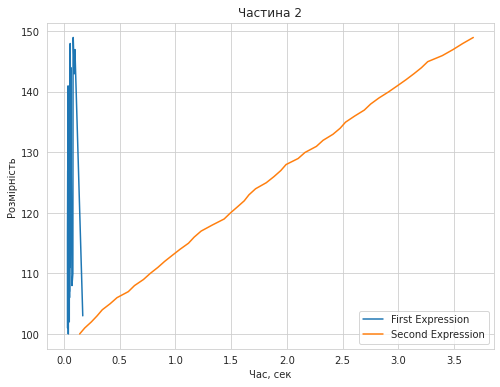

In [29]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=xs1, y=ys, label="First Expression")
sns.lineplot(x=xs2, y=ys, label="Second Expression")
plt.xlabel("Час, сек")
plt.ylabel("Розмірність")
plt.title("Частина 2")
plt.show()

In [30]:
with open(results_file_path, "a") as f:
    json.dump({"second_part": {"matrixes_MA": matrixes_MA, "vectors_E": vectors_E}}, f)

Запис результатів у файл